In [24]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [25]:
# Read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [26]:
len(words)

32033

In [27]:
# Build the volcabulary of charecters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [46]:
# Build the dataset
block_size = 3
X, Y = [], []

for w in words[:]:
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        # print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

In [47]:
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [48]:
X, Y

(tensor([[ 0,  0,  0],
         [ 0,  0,  5],
         [ 0,  5, 13],
         ...,
         [26, 26, 25],
         [26, 25, 26],
         [25, 26, 24]]),
 tensor([ 5, 13, 13,  ..., 26, 24,  0]))

In [49]:
C = torch.randn((27, 2))

In [50]:
C

tensor([[-0.4850,  0.3712],
        [ 0.0938, -0.9589],
        [-0.7900,  1.1831],
        [-1.1380, -0.7471],
        [-1.1190, -1.7061],
        [-1.1577,  1.2581],
        [ 1.5800, -0.4741],
        [-1.9287,  0.5255],
        [-0.4700, -0.5312],
        [-1.5005,  0.0385],
        [-0.3591,  0.2051],
        [-0.7696, -0.2200],
        [ 1.4581,  0.3644],
        [-0.6161,  0.7478],
        [-0.7819, -0.7356],
        [-1.8190,  0.3253],
        [ 1.2132,  0.4720],
        [ 2.6832,  2.0549],
        [ 0.4079, -0.4294],
        [ 0.5341,  1.3786],
        [ 0.0770,  0.5146],
        [-0.4883,  0.1939],
        [-0.5086, -0.5314],
        [ 1.3045,  0.7290],
        [ 0.1558,  0.4907],
        [-1.2812,  0.2797],
        [-0.9399, -1.4685]])

In [51]:
emb = C[X]

In [52]:
emb, emb.shape

(tensor([[[-0.4850,  0.3712],
          [-0.4850,  0.3712],
          [-0.4850,  0.3712]],
 
         [[-0.4850,  0.3712],
          [-0.4850,  0.3712],
          [-1.1577,  1.2581]],
 
         [[-0.4850,  0.3712],
          [-1.1577,  1.2581],
          [-0.6161,  0.7478]],
 
         ...,
 
         [[-0.9399, -1.4685],
          [-0.9399, -1.4685],
          [-1.2812,  0.2797]],
 
         [[-0.9399, -1.4685],
          [-1.2812,  0.2797],
          [-0.9399, -1.4685]],
 
         [[-1.2812,  0.2797],
          [-0.9399, -1.4685],
          [ 0.1558,  0.4907]]]),
 torch.Size([228146, 3, 2]))

In [53]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [54]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)

In [55]:
h

tensor([[-0.6040,  0.5426, -0.4168,  ..., -0.8414, -0.4657,  0.7946],
        [-0.6971,  0.5434, -0.6539,  ..., -0.9259, -0.3867, -0.1735],
        [-0.9066,  0.0512, -0.2247,  ..., -0.9909, -0.8647,  0.9510],
        ...,
        [ 0.9721,  0.2009, -0.9130,  ...,  0.9902,  0.9962,  0.6443],
        [ 0.1733, -0.1878,  0.8966,  ...,  0.8773,  0.9986,  0.9998],
        [ 0.9750,  0.2348, -0.9889,  ...,  0.6852, -0.6017,  0.6466]])

In [56]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [57]:
logits = h @ W2 + b2

In [58]:
counts = logits.exp()

In [59]:
prob = counts / counts.sum(1, keepdims=True)

In [60]:
prob.shape

torch.Size([228146, 27])

### Actual MLP Model

In [149]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [150]:
sum(p.nelement() for p in parameters) # number of parameters in total

11897

In [151]:
for p in parameters:
    p.requires_grad = True

In [152]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [153]:
lri = []
lossi = []
stepi = []

In [162]:
for i in range(50000):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32, ))
    
    # Forward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    # print(loss.item())
    
    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # Update
    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    stepi.append(i)
    lri.append(lr)
    lossi.append(loss.log10().item())

print(loss.item())

2.4568231105804443


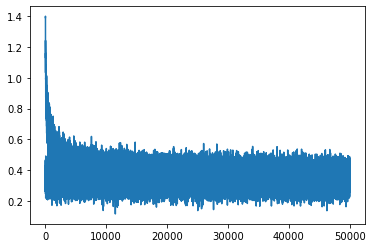

In [163]:
plt.plot(stepi, lossi)

In [164]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1783, grad_fn=<NllLossBackward0>)

In [165]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.2074, grad_fn=<NllLossBackward0>)

### Spliting data into train, dev and test

In [104]:
# build the dataset
block_size = 3 

def build_dataset(words):  
    X, Y = [], []
    
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


### Visualizing the embeddings

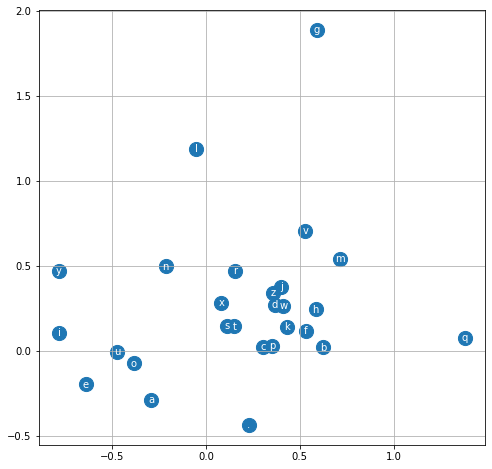

In [138]:
plt.figure(figsize=(8, 8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], ha='center', va='center', color='white')
plt.grid('minor')

### Generating names (some good names finally !!!)

In [177]:
# sample from the model
g = torch.Generator().manual_seed(3453973924)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        emb = C[torch.tensor([context])] # (1,block_size,d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out))

tori.
matrelys.
dayasrandelah.
michalyth.
peejeevalra.
ters.
luve.
jebnctte.
tme.
emme.
cliriella.
idhera.
jani.
melem.
kalie.
mayco.
chelee.
canmineo.
azyadumiy.
aar.
